In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#
# Advanced Life insurance mathematics: #
#            PC session 2              #
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

#### 0. Settings ####
# install.packages("tidyverse")
# install.packages("demography")
# install.packages("forecast")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
Be = pd.read_csv("LifeTableTransfer2.csv")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 5, saw 2


In [4]:
Belgium_male

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
12099,1950,0,0.06180,0.05900,0.23,100000,5900,95456,6381340,63.81
12100,1950,1,0.00381,0.00380,0.50,94100,358,93921,6285884,66.80
12101,1950,2,0.00214,0.00214,0.50,93742,200,93642,6191962,66.05
12102,1950,3,0.00162,0.00162,0.50,93542,151,93466,6098320,65.19
12103,1950,4,0.00105,0.00105,0.50,93391,98,93342,6004853,64.30
...,...,...,...,...,...,...,...,...,...,...
19753,2018,106,0.67756,0.50610,0.50,30,15,22,42,1.43
19754,2018,107,0.70705,0.52238,0.50,15,8,11,20,1.37
19755,2018,108,0.73490,0.53742,0.50,7,4,5,9,1.33
19756,2018,109,0.76099,0.55125,0.50,3,2,2,4,1.30


In [3]:
# colors - I copied most of these from # https://github.com/edrubin/EC524W20
KULbg = "#116E8A"

## ------------------------------------------------------------------------------------
Belgium_male_1x1 = pd.read_csv("Belgium_male_life_table_1x1.txt", delim_whitespace=True)
Belgium_male_1x1.columns = ["Year", "Age", "mx", "qx", "ax", "lx", "dx", "Lx", "Tx", "ex"]

## ------------------------------------------------------------------------------------
Belgium_male_1x1.columns

## ------------------------------------------------------------------------------------
min(Belgium_male_1x1["Year"])
max(Belgium_male_1x1["Year"])

## ------------------------------------------------------------------------------------
min(Belgium_male_1x1["Age"])
max(Belgium_male_1x1["Age"])

## ------------------------------------------------------------------------------------
start_year = 1950
end_year = max(Belgium_male_1x1["Year"])

Belgium_male = Belgium_male_1x1[(Belgium_male_1x1["Year"]).fillna(0).astype(int) >= start_year]

Belgium_male[["Year", "Age", "mx", "qx", "lx", "dx", "ex"]]

/var/folders/n3/j9s0z6s92fd1_xkmg3xk0twh0000gn/T/ipykernel_2049/435357777.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Belgium_male_1x1 = pd.read_csv("Belgium_male_life_table_1x1.txt", delim_whitespace=True)


,Year,Age,mx,qx,lx,dx,ex
12099,1950,0,0.06180,0.05900,100000,5900,63.81
12100,1950,1,0.00381,0.00380,94100,358,66.80
12101,1950,2,0.00214,0.00214,93742,200,66.05
12102,1950,3,0.00162,0.00162,93542,151,65.19
12103,1950,4,0.00105,0.00105,93391,98,64.30
...,...,...,...,...,...,...,...
19753,2018,106,0.67756,0.50610,30,15,1.43
19754,2018,107,0.70705,0.52238,15,8,1.37
19755,2018,108,0.73490,0.53742,7,4,1.33
19756,2018,109,0.76099,0.55125,3,2,1.30


In [39]:
Belgium_male["mx"] = Belgium_male["mx"].astype(float)

/var/folders/n3/j9s0z6s92fd1_xkmg3xk0twh0000gn/T/ipykernel_5964/1373066906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Belgium_male["mx"] = Belgium_male["mx"].astype(float)


#### 1. Least-squares approach: iterative approach ####

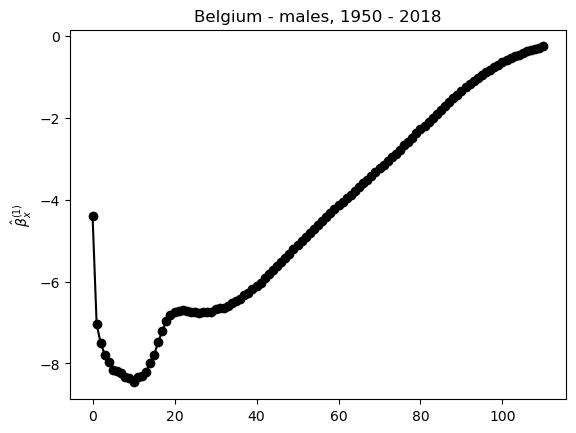

In [40]:
## Alpha is estimated immediately, beta and kappa iteratively ##

#### 1.1. Estimate alpha ####
X = pd.get_dummies(Belgium_male["Age"]).values
y = np.log(Belgium_male["mx"].astype(float)).values

alpha_est_expl = np.linalg.solve(X.T @ X, X.T @ y)
alpha_est = sm.OLS(y, X).fit().params

## ------------------------------------------------------------------------------------
data = pd.DataFrame({"age": np.arange(0, 111), "fit": alpha_est})
g = plt.plot(data["age"], data["fit"], "o-", color="black")
plt.title("Belgium - males, 1950 - 2018")
plt.ylabel(r"$\hat{\beta}_x^{(1)}$")
plt.show()

#### 1.2. Estimate kappa's: initialization ####

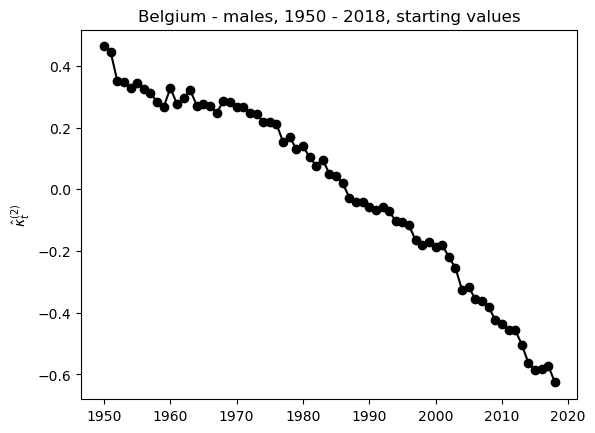

In [53]:
## Create new response variable: Z = log(mx) - alpha ##
Z = np.log(Belgium_male["mx"]) - alpha_est[Belgium_male["Age"] - min(Belgium_male["Age"])]

X = pd.get_dummies(Belgium_male["Year"]).values

kappa_est_expl = np.linalg.solve(X.T @ X, X.T @ Z)

kappa_est = sm.OLS(Z, X).fit().params

## ------------------------------------------------------------------------------------
data = pd.DataFrame({"year": np.arange(start_year, end_year + 1), "fit": kappa_est})
g = plt.plot(data["year"], data["fit"], "o-", color="black")
plt.title("Belgium - males, 1950 - 2018, starting values")
plt.ylabel(r"$\hat{\kappa}_t^{(2)}$")
plt.show()

#### 1.3. Estimate betas: initialization ####

x1     0.463221
x2     0.445113
x3     0.352394
x4     0.347657
x5     0.328220
         ...   
x65   -0.563030
x66   -0.584812
x67   -0.583551
x68   -0.571770
x69   -0.626314
Length: 69, dtype: float64


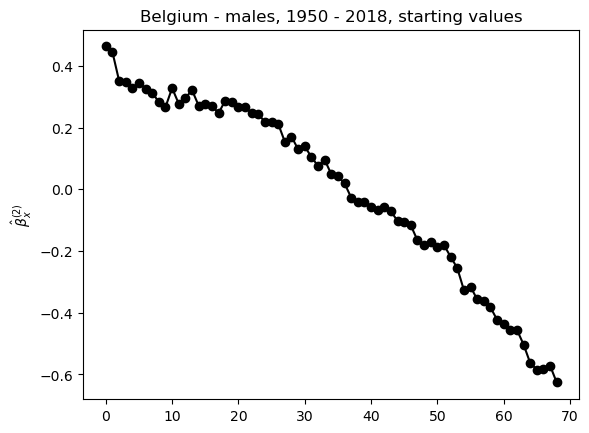

In [61]:
# Calculate kappa_est
kappa_est = var_kappa[Belgium_male['Year'] - Belgium_male['Year'].min() + 1]
Z = np.log(Belgium_male["mx"]) - alpha_est[Belgium_male["Age"] - min(Belgium_male["Age"])]

X = pd.get_dummies(Belgium_male["Year"]).values
# Fit linear regression model
model = sm.OLS(Z, X).fit().params
#results = model.fit()

# Extract coefficients
#beta_est = model.params

print(model)
data = pd.DataFrame({"age": np.arange(0, 69), "fit": model})
g = plt.plot(data["age"], data["fit"], "o-", color="black")
plt.title("Belgium - males, 1950 - 2018, starting values")
plt.ylabel(r"$\hat{\beta}_x^{(2)}$")
plt.show()

/var/folders/n3/j9s0z6s92fd1_xkmg3xk0twh0000gn/T/ipykernel_5964/239797941.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_kappa = kappa_est[Belgium_male["Year"] - min(Belgium_male["Year"])]


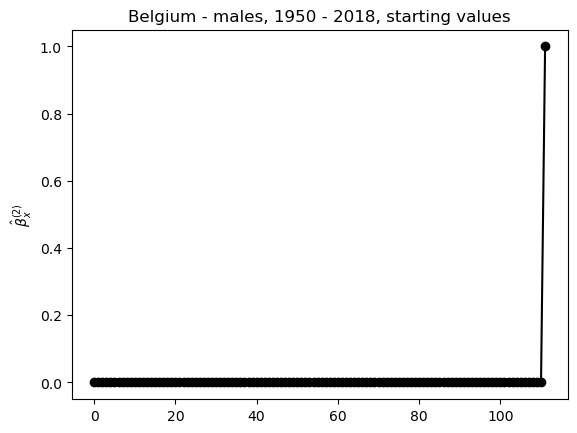

In [43]:
## create variable with kappa's as values ##
var_kappa = kappa_est[Belgium_male["Year"] - min(Belgium_male["Year"])]

## : in model formula -> interaction term ##
X = np.hstack((pd.get_dummies(Belgium_male["Age"]).values, var_kappa.values.reshape(-1, 1)))

beta_est_expl = np.linalg.solve(X.T @ X, X.T @ Z)

beta_est = sm.OLS(Z, X).fit().params

## ------------------------------------------------------------------------------------
data = pd.DataFrame({"age": np.arange(0, 112), "fit": beta_est})
g = plt.plot(data["age"], data["fit"], "o-", color="black")
plt.title("Belgium - males, 1950 - 2018, starting values")
plt.ylabel(r"$\hat{\beta}_x^{(2)}$")
plt.show()

#### 1.4. Incorporate this in algorithm ####

In [49]:
converged = False
iter = 1

while not converged:
    beta_est_old = beta_est
    kappa_est_old = kappa_est

    # (2): estimate kappa's
    var_beta = beta_est[Belgium_male["Age"] - min(Belgium_male["Age"])]
    X = np.hstack((pd.get_dummies(Belgium_male["Year"]), var_beta.reshape(-1, 1)))
    kappa_est = np.linalg.solve(X.T @ X, X.T @ Z)

    # (3): estimate beta's
    var_kappa = kappa_est[Belgium_male["Year"] - min(Belgium_male["Year"])]
    X = np.hstack((pd.get_dummies(Belgium_male["Age"]), var_kappa.reshape(-1, 1)))
    beta_est = np.linalg.solve(X.T @ X, X.T @ Z)

    # stopping criterion
    converged = np.max(np.abs(beta_est - beta_est_old) / np.abs(beta_est_old)) < 1e-8 and np.max(
        np.abs(kappa_est - kappa_est_old) / np.abs(kappa_est_old)) < 1e-8
    iter += 1
    if iter % 1e2 == 0:
        print("\n\nIteration number", iter, "\n\n")

## ------------------------------------------------------------------------------------
data = pd.DataFrame({"age": np.arange(0, 111), "fit": beta_est, "init": beta_est_expl})
g = plt.plot(data["age"], data["fit"], "o-", color="black")
plt.plot(data["age"], data["init"], "o-", color="red")
plt.title("Belgium - males, 1950 - 2018, starting + final values")
plt.ylabel(r"$\hat{\beta}_x^{(2)}$")
plt.show()

## ------------------------------------------------------------------------------------
## apply constraints ##
beta_est_LS = beta_est / np.sum(beta_est)
kappa_est_LS = (kappa_est - np.mean(kappa_est)) * np.sum(beta_est)
alpha_est_LS = alpha_est + beta_est * np.mean(kappa_est)

## ------------------------------------------------------------------------------------
np.sum(beta_est_LS)
np.sum(kappa_est_LS)

## ------------------------------------------------------------------------------------
data_period = pd.DataFrame({"year": np.arange(start_year, end_year + 1), "fit": kappa_est, "init": kappa_est_expl})
data_age = pd.DataFrame({"age": np.arange(0, 111), "fit_alpha": alpha_est, "fit_beta": beta_est})

g_1 = plt.plot(data_age["age"], data_age["fit_alpha"], "o-", color="black")
plt.title("Belgium - males, 1950 - 2018, final estimates")
plt.ylabel(r"$\hat{\beta}_x^{(1)}$")
plt.show()

g_2 = plt.plot(data_age["age"], data_age["fit_beta"], "o-", color="black")
plt.title("")
plt.ylabel(r"$\hat{\beta}_x^{(2)}$")
plt.show()

g_3 = plt.plot(data_period["year"], data_period["fit"], "o-", color="black")
plt.title("")
plt.ylabel(r"$\hat{\kappa}_t^{(2)}$")
plt.show()



Iteration number 100 




Iteration number 200 




Iteration number 300 




Iteration number 400 




Iteration number 500 




Iteration number 600 




Iteration number 700 




Iteration number 800 




Iteration number 900 




Iteration number 1000 




Iteration number 1100 




Iteration number 1200 




Iteration number 1300 




Iteration number 1400 




Iteration number 1500 




Iteration number 1600 




Iteration number 1700 




Iteration number 1800 




Iteration number 1900 




Iteration number 2000 




Iteration number 2100 




Iteration number 2200 




Iteration number 2300 




Iteration number 2400 




Iteration number 2500 




Iteration number 2600 




Iteration number 2700 




Iteration number 2800 




Iteration number 2900 




Iteration number 3000 




Iteration number 3100 




Iteration number 3200 




Iteration number 3300 




Iteration number 3400 




Iteration number 3500 




Iteration number 3600 




Iteration number 3700 




Iteratio

KeyboardInterrupt: 

## 2. Lee-carter: GLM formulation ##

### 2.0 Data ##

In [50]:
country = ["BEL", "Belgium"]
user = "vuulenbak42@hotmail.com"
pw = "testEAA"
df = hmd.mx(country[1], user, pw, country[2])
years = np.arange(1970, max(df["year"]) + 1)
ages = np.arange(0, 90)

#### Creates subset of demogdata object
df = df[df["year"].isin(years)]
df = df[df["age"].isin(ages)]

min(df["year"])
max(df["year"])
max(df["age"])

## ------------------------------------------------------------------------------------
etx = df.pivot(index="age", columns="year", values="male")
etx.shape

dtx = etx * df.pivot(index="age", columns="year", values="rate")
dtx.shape

## ------------------------------------------------------------------------------------
df = pd.DataFrame({"Year": years, "Age": ages})
rates = dtx / etx
df["rates"] = np.log(rates.values.flatten())
df.columns = ["Year", "Age", "logRate"]

p = plt.plot(df["Age"], df["logRate"], "o-", color="black")
plt.title("Belgium - males, 1970 - 2018")
plt.ylabel(r"$\log m_x$")
plt.xlabel("Age (x)")
plt.show()

#### 2. Poisson likelihood and NR scheme ####

#### 2.1. Poisson GLM: using fit701 function ####

LCfit701 = fit701(ages, years, etx, dtx, np.ones((len(years), len(ages))))

## ------------------------------------------------------------------------------------
LCfit701.keys()

## ------------------------------------------------------------------------------------
data_period = pd.DataFrame({"year": years, "fit": LCfit701["kappa2"]})
data_age = pd.DataFrame({"age": ages, "fit_alpha": LCfit701["beta1"], "fit_beta": LCfit701["beta2"]})

g_1 = plt.plot(data_age["age"], data_age["fit_alpha"], "o-", color="black")
plt.title("Belgium - males, 1970 - 2018, Lee Carter, Poisson")
plt.ylabel(r"$\hat{\beta}_x^{(1)}$")
plt.show()

g_2 = plt.plot(data_age["age"], data_age["fit_beta"], "o-", color="black")
plt.title("")
plt.ylabel(r"$\hat{\beta}_x^{(2)}$")
plt.show()

g_3 = plt.plot(data_period["year"], data_period["fit"], "o-", color="black")
plt.title("")
plt.ylabel(r"$\hat{\kappa}_t^{(2)}$")
plt.show()

NameError: name 'hmd' is not defined

#### 2.2. Using self-written function ####

In [51]:
## Function ##
def LL(dxt, ext, Beta, Kappa):
    Mat = np.empty_like(dxt)
    for i in range(dxt.shape[0]):
        for j in range(dxt.shape[1]):
            Mat[i, j] = dxt[i, j] * (Beta[i, 0] * Beta[i, 1] * Kappa[j]) - ext[i, j] * np.exp(Beta[i, 0] * Beta[i, 1] * Kappa[j])
    return np.sum(np.apply_along_axis(np.sum, 1, Mat))

def LCNRopt(dxt, ext, eps=1e-4, maxiter=1e4):
    mxt = dxt / ext
    m = ext.shape[1]
    def LL(dxt, ext, Beta, Kappa):
        Mat = np.empty_like(dxt)
        for i in range(dxt.shape[0]):
            for j in range(dxt.shape[1]):
                Mat[i, j] = dxt[i, j] * (Beta[i, 0] * Beta[i, 1] * Kappa[j]) - ext[i, j] * np.exp(Beta[i, 0] * Beta[i, 1] * Kappa[j])
        return np.sum(np.apply_along_axis(np.sum, 1, Mat))
    Beta = np.column_stack((np.apply_along_axis(np.sum, 1, np.log(mxt)) / mxt.shape[1], np.repeat(1 / mxt.shape[0], mxt.shape[0])))
    Kappa = np.arange(m, 0, -1) - (m + 1) / 2
    Conv = False
    iter = 0
    LogL = []
    LogL.append(LL(dxt, ext, Beta, Kappa))
    while not Conv:
        if iter % 1000 == 0:
            print("\n\nIteration number", iter, "\n\n")
        for i in range(dxt.shape[0]):
            B0i = Beta[i, 0]
            B2i = Beta[i, 1]
            dxti = dxt[i, :]
            exti = ext[i, :]
            B1i = B0i - (np.sum(dxti - exti * np.exp(B0i + B2i * Kappa))) / - (np.sum(exti * np.exp(B0i + B2i * Kappa)))
            while np.abs(B0i - B1i) > 0.01:
                B0i = B1i
                B1i = B0i - (np.sum(dxti - exti * np.exp(B0i + B2i * Kappa))) / - (np.sum(exti * np.exp(B0i + B2i * Kappa)))
            Beta[i, 0] = B1i
        for i in range(dxt.shape[1]):
            B1 = Beta[:, 0]
            B2 = Beta[:, 1]
            dxti = dxt[:, i]
            exti = ext[:, i]
            K0i = Kappa[i]
            K1i = K0i - (np.sum((dxti - exti * np.exp(B1 + B2 * K0i)) * B2)) / - (np.sum(exti * np.exp(B1 + B2 * K0i) * B2 ** 2))
            while np.abs(K1i - K0i) > 0.01:
                K0i = K1i
                K1i = K0i - (np.sum((dxti - exti * np.exp(B1 + B2 * K0i)) * B2)) / - (np.sum(exti * np.exp(B1 + B2 * K0i) * B2 ** 2))
            Kappa[i] = K1i
        SumB2 = np.sum(Beta[:, 1])
        AvgKappa = np.mean(Kappa)
        Kappa = SumB2 * (Kappa - AvgKappa)
        Beta[:, 1] = Beta[:, 1] / SumB2
        Beta[:, 0] = Beta[:, 0] + Beta[:, 1] * SumB2 * AvgKappa
        for i in range(dxt.shape[0]):
            B0i = Beta[i, 0]
            B2i = Beta[i, 1]
            dxti = dxt[i, :]
            exti = ext[i, :]
            B2.1i = B2i - (np.sum((dxti - exti * np.exp(B0i + B2i * Kappa)) * Kappa)) / - (np.sum(exti * (np.exp(B0i + (B2i * Kappa)))) * Kappa ** 2)
            while np.abs(B2i - B2.1i) > 0.01:
                B2i = B2.1i
                B2.1i = B2i - (np.sum((dxti - exti * np.exp(B0i + B2i * Kappa)) * Kappa)) / - (np.sum(exti * (np.exp(B0i + B2i * Kappa)) * Kappa ** 2))
            Beta[i, 1] = B2.1i
        iter += 1
        LogL.append(LL(dxt, ext, Beta, Kappa))
        if np.abs(LogL[iter] - LogL[iter - 1]) < eps:
            break
        if iter > maxiter:
            break
    if iter > maxiter:
        print("Maximum number of iterations exceeded.")
    return {"Beta": Beta, "Kappa": Kappa, "LogL": LogL}

LeeCarterNR = LCNRopt(dtx.T, etx.T, eps=1e-4, maxiter=2e3)

Results = {"x": ages, "y": years, "beta1": LeeCarterNR["Beta"][:, 0], "beta2": LeeCarterNR["Beta"][:, 1], "kappa2": LeeCarterNR["Kappa"]}

## ------------------------------------------------------------------------------------
data_period = pd.DataFrame({"year": years, "fit": Results["kappa2"]})
data_age = pd.DataFrame({"age": ages, "fit_alpha": Results["beta1"], "fit_beta": Results["beta2"]})

g_1 = plt.plot(data_age["age"], data_age["fit_alpha"], "o-", color="black")
plt.title("Belgium - males, 1970 - 2018, Lee Carter, Poisson")
plt.ylabel(r"$\hat{\beta}_x^{(1)}$")
plt.show()

g_2 = plt.plot(data_age["age"], data_age["fit_beta"], "o-", color="black")
plt.title("")
plt.ylabel(r"$\hat{\beta}_x^{(2)}$")
plt.show()

g_3 = plt.plot(data_period["year"], data_period["fit"], "o-", color="black")
plt.title("")
plt.ylabel(r"$\hat{\kappa}_t^{(2)}$")
plt.show()

SyntaxError: invalid syntax (3250939253.py, line 58)

#### 2.3. Residual plots ####

In [ ]:
grid = pd.DataFrame({"period": years, "age": ages})
grid["res"] = LCfit701["epsilon"].flatten()

## ------------------------------------------------------------------------------------
grid.head()

## ------------------------------------------------------------------------------------
grid = pd.DataFrame({"period": years, "age": ages})
grid["res"] = LCfit701["epsilon"].flatten()

p = plt.scatter(grid["period"], grid["age"], c=grid["res"], cmap="coolwarm")
plt.colorbar(p)
plt.title("Residual plot")
plt.xlabel("Year")
plt.ylabel("Age")
plt.show()

#### 2.4. Inspecting goodness of fit: observed mx versus fitted mx ####

age = 25
rates = dtx / etx
df = pd.DataFrame({"Year": years, "obs": rates[:, age - min(ages)], "fit": np.exp(LCfit701["beta1"][age - min(ages)] + LCfit701["beta2"][age - min(ages)] * LCfit701["kappa2"])})

g_25 = plt.plot(df["Year"], df["obs"], "o-", color="black")
plt.plot(df["Year"], df["fit"], "--", color="black")
plt.title("Belgium - males, 1970 - 2018, Lee Carter, Poisson")
plt.ylabel(r"$\hat{m}_{25,t}$")
plt.xlabel("Year (t)")
plt.show()

age = 45
rates = dtx / etx
df = pd.DataFrame({"Year": years, "obs": rates[:, age - min(ages)], "fit": np.exp(LCfit701["beta1"][age - min(ages)] + LCfit701["beta2"][age - min(ages)] * LCfit701["kappa2"])})

g_45 = plt.plot(df["Year"], df["obs"], "o-", color="black")
plt.plot(df["Year"], df["fit"], "--", color="black")
plt.title("Belgium - males, 1970 - 2018, Lee Carter, Poisson")
plt.ylabel(r"$\hat{m}_{45,t}$")
plt.xlabel("Year (t)")
plt.show()

age = 65
rates = dtx / etx
df = pd.DataFrame({"Year": years, "obs": rates[:, age - min(ages)], "fit": np.exp(LCfit701["beta1"][age - min(ages)] + LCfit701["beta2"][age - min(ages)] * LCfit701["kappa2"])})

g_65 = plt.plot(df["Year"], df["obs"], "o-", color="black")
plt.plot(df["Year"], df["fit"], "--", color="black")
plt.title("Belgium - males, 1970 - 2018, Lee Carter, Poisson")
plt.ylabel(r"$\hat{m}_{65,t}$")
plt.xlabel("Year (t)")
plt.show()

age = 85
rates = dtx / etx
df = pd.DataFrame({"Year": years, "obs": rates[:, age - min(ages)], "fit": np.exp(LCfit701["beta1"][age - min(ages)] + LCfit701["beta2"][age - min(ages)] * LCfit701["kappa2"])})

g_85 = plt.plot(df["Year"], df["obs"], "o-", color="black")
plt.plot(df["Year"], df["fit"], "--", color="black")
plt.title("Belgium - males, 1970 - 2018, Lee Carter, Poisson")
plt.ylabel(r"$\hat{m}_{85,t}$")
plt.xlabel("Year (t)")
plt.show()

#### 2.5. Forecasting with time series ####

In [ ]:
time_series = sm.tsa.arima.ARIMA(LCfit701["kappa2"], order=(0, 1, 0), include_drift=True).fit()

time_series

## ------------------------------------------------------------------------------------
plt.plot(time_series.forecast(10)[0])
plt.title("Forecasting with time series")
plt.show()

#### 2.6. Forecasting with the model: longevity charts ####

In [1]:
sim_LC = sim2001(xx=LCfit701["x"], yy=LCfit701["y"], beta1v=LCfit701["beta1"], beta2v=LCfit701["beta2"], kappa2v=LCfit701["kappa2"], nsim=10000, tmax=50, nyears=len(years))

## ------------------------------------------------------------------------------------
sim_LC["y"]

sim_LC["dda"].shape

sim_LC["dda"][:, :50, 0]

LCfit701["kappa2"][-1]

sim_LC["qaa"].shape

## ------------------------------------------------------------------------------------
# time series kappa_t
plt.plot(LCfit701["y"], LCfit701["kappa2"], "o-", color="black", xlim=(1970, 2068), ylim=(min(LCfit701["kappa2"]), max(LCfit701["kappa2"])), title=r"Projection of $\kappa_t$", sub="ARIMA(0,1,0), 10000 sim", xlab="Year (t)", ylab=r"$\kappa_t$")
# fan chart
fan(LCfit701["y"], sim_LC["dda"], color="red")

## ------------------------------------------------------------------------------------
age = 65
minage = min(ages)

plt.plot(LCfit701["y"], np.exp(LCfit701["beta1"][age - minage] + LCfit701["beta2"][age - minage] * LCfit701["kappa2"]), "r-", linewidth=2)
fan(LCfit701["y"], np.exp(LCfit701["beta1"][age - minage] + LCfit701["beta2"][age - minage] * sim_LC["dda"]), color="red")
plt.scatter(LCfit701["y"], rates[:, age - minage], color="black", marker="o")

## ------------------------------------------------------------------------------------
ages_sel = [65, 75, 85]
nages = len(ages_sel)
color = ["red", "green", "blue"]

plt.plot([1970, 2068], [0.005, 0.2], "n", log="y", linewidth=2, color="black", title=r"Belgium: projection of $q_{65}(t), q_{75}(t), q_{85}(t)$", sub="ARIMA(0,1,0), 10000 sim", xlab="Year (t)", ylab=r"$q_{65}(t), q_{75}(t), q_{85}(t)$")

for j in range(nages):
    plt.plot(LCfit701["y"], 1 - np.exp(-np.exp(LCfit701["beta1"][ages_sel[j] - minage] + LCfit701["beta2"][ages_sel[j] - minage] * LCfit701["kappa2"])), color=color[j], linewidth=2)
    plt.plot(sim_LC["y"], sim_LC["qaa"][ages_sel[j] - minage, :, :], color="grey")

p = np.arange(0.05, 1, 0.05)

for j in range(nages):
    q_int = np.zeros((50, len(p)))
    for i in range(50):
        q_int[i, :] = np.quantile(sim_LC["qaa"][ages_sel[j] - minage, i, :], p=p)
    plt.plot(range(2018, 2068), q_int[:, 0], color=color[j], linestyle="-", linewidth=2)
    plt.plot(range(2018, 2068), q_int[:, -1], color=color[j], linestyle="-", linewidth=2)

## ------------------------------------------------------------------------------------
ages_sel = [65, 75, 85]
nages = len(ages_sel)
color = ["red", "green", "blue"]

plt.plot([1970, 2058], [0.005, 0.2], "n", log="y", linewidth=2, color="black", title=r"Belgium: projection of $q_{65}(t), q_{75}(t), q_{85}(t)$", sub="ARIMA(0,1,0), 10000 sim", xlab="Year (t)", ylab=r"$q_{65}(t), q_{75}(t), q_{85}(t)$")

for j in range(nages):
    plt.plot(LCfit701["y"], 1 - np.exp(-np.exp(LCfit701["beta1"][ages_sel[j] - minage] + LCfit701["beta2"][ages_sel[j] - minage] * LCfit701["kappa2"])), color=color[j], linewidth=2)
    plt.plot(sim_LC["y"], sim_LC["qaa"][ages_sel[j] - minage, :, :], color="grey")

fan(sim_LC["y"], sim_LC["qaa"][ages_sel[j] - minage, :, :], col="red")

## ------------------------------------------------------------------------------------
ages_sel = [65, 75, 85]
nages = len(ages_sel)
color = ["red", "green", "blue"]

plt.plot([1970, 2058], [0.005, 0.2], "n", log="y", linewidth=2, color="black", title=r"Belgium: projection of $q_{65}(t), q_{75}(t), q_{85}(t)$", sub="ARIMA(0,1,0), 10000 sim", xlab="Year (t)", ylab=r"$q_{65}(t), q_{75}(t), q_{85}(t)$")

for j in range(nages):
    plt.plot(LCfit701["y"], 1 - np.exp(-np.exp(LCfit701["beta1"][ages_sel[j] - minage] + LCfit701["beta2"][ages_sel[j] - minage] * LCfit701["kappa2"])), color=color[j], linewidth=2)
    plt.plot(sim_LC["y"], sim_LC["qaa"][ages_sel[j] - minage, :, :], color="grey")

fan(sim_LC["y"], sim_LC["qaa"][ages_sel[j] - minage, :, :], col="red")

SyntaxError: invalid syntax (852774877.py, line 289)